In [1]:
import cv2
from  matplotlib import pyplot as plt
%matplotlib inline

cv2_imshow = lambda x:plt.imshow(x[:,:,::-1])
import numpy as np
import sys
sys.path.append("MyDepth")
from boilerplate import *
input_picture_directory = system_data_path/'5.跨场景单目深度估计/决赛数据/final_b'
input_np.np.np.picture_directory

/home/ycm/program_files/miniconda3/envs/depth/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


batch_size=4


PosixPath('/data/projects/depth/5.跨场景单目深度估计/决赛数据/final_b')

In [25]:
# 相机内参
fx = 549.0869836743506
fy = 549.0393143358732
cx = 664.8310221457081
cy = 368.30351397130175
k1 = -0.037032730499053215
k2 = -9.331683195791314e-05
k3 = -0.0025427846701313096
k4 = 0.0005759176479469663

# 相机参数
camera_matrix = np.array([[fx, 0, cx],
                          [0, fy, cy],
                          [0, 0, 1]])

dist_coeffs = np.array([k1, k2, k3, k4])

# width = 1280*1.2
width = 1280
# 计算FOV
fov_x = 2 * np.arctan(width / (2 * fx))

# 将弧度转换为度
fov_x_deg = np.degrees(fov_x)

print(f'FOV_x (in radians): {fov_x}')
print(f'FOV_x (in degrees): {fov_x_deg}')

FOV_x (in radians): 1.7234117215810412
FOV_x (in degrees): 98.74421800996896


(720, 1280, 3)


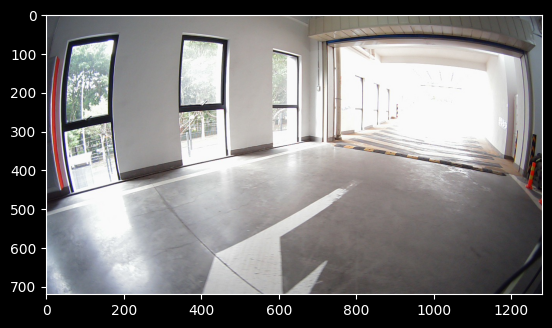

In [55]:
img = cv2.imread((input_picture_directory/'img_0000.jpg').as_posix())
img = cv2.imread((input_picture_directory/'img_0001.jpg').as_posix())
print(img.shape)
cv2_imshow(img)

In [56]:
img.shape
# img.shape[1:-1:0]
wh = img.shape[-2:-4:-1]
wh
# img.shape[1:0:-1]

(1280, 720)

(720, 1280, 3)


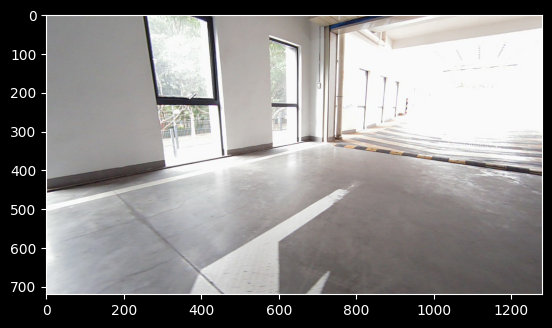

In [57]:
# 消除鱼眼
map1, map2 = cv2.fisheye.initUndistortRectifyMap(K=camera_matrix, D=dist_coeffs, R=np.eye(3), P=camera_matrix, 
                                                 size=img.shape[-2:-4:-1], 
                                                # (np.array(wh)*2.5).astype(int),
                                                # size=(np.array(wh)*3).astype(int),
                                                #  cv2.CV_16SC2
                                                # m1type=cv2.CV_32FC1
                                                m1type=cv2.CV_16SC2
                                                 )
undistorted_img = cv2.remap(img, map1, 
                            map2, 
                            # None, 
                            interpolation=cv2.INTER_LINEAR, 
                            borderMode=cv2.BORDER_CONSTANT)
print(undistorted_img.shape)
cv2_imshow(undistorted_img)

In [58]:
# coordinates = np.zeros((int(wh[1]/1.5), int(wh[0]/1.5), 2), dtype=np.float32)
# coordinates = np.zeros((int(wh[1]/1.2), int(wh[0]/1.2), 2), dtype=np.float32)
coordinates = np.zeros((int(wh[1]), int(wh[0]), 2), dtype=np.float32)
for i in range(coordinates.shape[0]):
    for j in range(coordinates.shape[1]):
        coordinates[i, j, :] = [i, j]
        # coordinates[i, j, :] = [i+300, j+40]
        # coordinates[i, j, :] = [i+200, j+40]
        # coordinates[i, j, :] = [(i+200)/2+200, 
        #                         (j+50)/2+20]
# coordinates

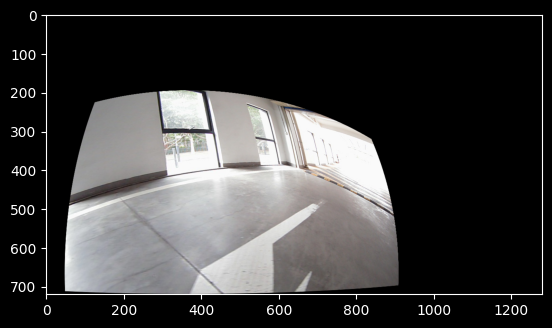

In [63]:
maps = cv2.fisheye.undistortPoints(coordinates, K=camera_matrix, D=dist_coeffs, R=np.eye(3), P=camera_matrix)
inv_map1, inv_map2 = maps[:, :, 1], maps[:, :, 0]
inv_map1, inv_map2 = cv2.convertMaps(inv_map1, inv_map2, dstmap1type=cv2.CV_16SC2)
distorted = cv2.remap(undistorted_img, inv_map1, inv_map2, interpolation=cv2.INTER_LINEAR, 
# distorted = cv2.remap(img, inv_map1, inv_map2, interpolation=cv2.INTER_LINEAR, 
                            borderMode=cv2.BORDER_CONSTANT)
cv2_imshow(distorted)

num_labels:  2


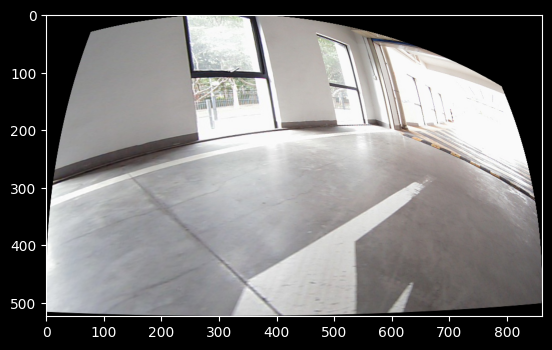

In [64]:
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(cv2.cvtColor (distorted, cv2.COLOR_BGR2GRAY))
print('num_labels: ', num_labels)
for i, st in enumerate(stats[1:]):
    x0 = st[0]
    y0 = st[1]
    x1 = st[0] + st[2]
    y1 = st[1] + st[3]
    image_show = np.copy(distorted)
    cv2.rectangle(image_show, (x0, y0), (x1, y1), (255, 255, 255), 3)
    distorted = distorted[y0:y1, x0:x1]
# cv2_imshow(image_show)
cv2_imshow(distorted)

100%|██████████| 360/360 [00:03<00:00, 109.67it/s]


(360, 2261, 3)


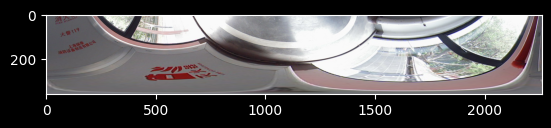

In [189]:
## 横向展开法
# https://zhuanlan.zhihu.com/p/402329678
R=img.shape[0]//2
W=int(2*np.pi*R)
H=R
mapx = np.zeros([H, W], dtype=np.float32)
mapy = mapx.copy()
from tqdm import tqdm
for i in tqdm(range(mapx.shape[0])):
    for j in range(mapx.shape[1]):
        angle = j/W*np.pi*2
        radius=H-i
        mapx[i, j] = R+np.sin(angle)*radius
        mapy[i, j] = R-np.cos(angle)*radius
undistorted_img = cv2.remap(img, mapx, 
                            mapy, 
                            # None, 
                            interpolation=cv2.INTER_LINEAR, 
                            borderMode=cv2.BORDER_CONSTANT)
print(undistorted_img.shape)
cv2_imshow(undistorted_img)

In [33]:
# 经纬度法
# https://gitee.com/rxdj/DewarpFisheye/blob/master/warpFisheyeImg.cpp
# https://blog.csdn.net/yangpan011/article/details/80566969
def rectify_map(in_width, in_height, rot, out_width, out_height, fov, radius):
    # 中心位置
    cx = in_width / 2.0
    cy = in_height / 2.0

    map_img = np.zeros((out_height, out_width, 2), dtype=np.float32)

    for j in tqdm(range(out_height)):
        theta1 = j * np.pi / out_height
        sin_theta1 = np.sin(theta1)
        z1 = np.cos(theta1)

        for i in range(out_width):
            fi1 = 2 * np.pi - i * 2 * np.pi / out_width
            x1 = sin_theta1 * np.cos(fi1)
            y1 = sin_theta1 * np.sin(fi1)

            # 归一化三维坐标
            x2 = rot[0] * x1 + rot[1] * y1 + rot[2] * z1
            y2 = rot[3] * x1 + rot[4] * y1 + rot[5] * z1
            z2 = rot[6] * x1 + rot[7] * y1 + rot[8] * z1
            norm = np.sqrt(x2**2 + y2**2 + z2**2)
            x2 /= norm
            y2 /= norm
            z2 /= norm

            # 球面坐标系转换
            theta2 = np.degrees(np.arccos(z2))
            fi2 = np.arctan2(y2, x2)

            if 0 <= theta2 <= (fov / 2):
                # 球面到鱼眼
                radius2 = radius * theta2 / (fov / 2)
                u = radius2 * np.cos(fi2) + cx
                v = radius2 * np.sin(fi2) + cy

                if 0 <= u < in_width - 1 and 0 <= v < in_height - 1:
                    map_img[j, i, 0] = u
                    map_img[j, i, 1] = v
                else:
                    map_img[j, i, 0] = 0
                    map_img[j, i, 1] = 0
            else:
                map_img[j, i, 0] = 0
                map_img[j, i, 1] = 0

    return map_img
def inv_rectify_map(in_width, in_height, rot, out_width, out_height, fov, radius):
    cx = out_width / 2.0
    cy = out_height / 2.0

    map_img = np.zeros((out_height, out_width, 2), dtype=np.float32)

    for j in range(out_height):
        for i in range(out_width):
            fi2 = np.arctan2(j - cy, i - cx)
            if fi2 < 0:
                fi2 += 2 * np.pi

            radius2 = abs(i - cx) if abs(np.sin(fi2)) < 1e-3 else abs((j - cy) / np.sin(fi2))
            theta2 = radius2 * fov / (radius * 2)

            if 0 <= theta2 <= (fov / 2):
                z2 = np.cos(np.radians(theta2))
                x2 = 0 if abs(fi2 - np.pi / 2) < 1e-3 or abs(fi2 - 3 * np.pi / 2) < 1e-3 else np.sqrt(1 - z2**2) / (1 + np.tan(fi2)**2)
                x2 *= -1 if (fi2 < 3 * np.pi / 2) and (fi2 > np.pi / 2) else 1
                y2 = np.sqrt(1 - x2**2 - z2**2)
                y2 *= -1 if (fi2 < 2 * np.pi) and (fi2 > np.pi) else 1

                norm = np.sqrt(x2**2 + y2**2 + z2**2)
                x2 /= norm
                y2 /= norm
                z2 /= norm

                x1 = rot[0] * x2 + rot[1] * y2 + rot[2] * z2
                y1 = rot[3] * x2 + rot[4] * y2 + rot[5] * z2
                z1 = rot[6] * x2 + rot[7] * y2 + rot[8] * z2

                theta1 = np.arccos(z1)
                fi1 = np.arccos(x1 / np.sin(theta1)) + np.pi / 2 if abs(np.sin(theta1)) > 1e-3 else np.pi / 2

                u = (2 * np.pi - fi1) * in_width / (2 * np.pi)
                v = theta1 * in_height / np.pi

                if 0 <= u < in_width - 1 and 0 <= v < in_height - 1:
                    map_img[j, i, 0] = u
                    map_img[j, i, 1] = v
            else:
                map_img[j, i, 0] = 0
                map_img[j, i, 1] = 0

    return map_img
in_width = wh[1]
in_height = wh[0]
# in_width = wh[0]
# in_height = wh[1]
# out_width = wh[0]//2
# out_height = wh[1]//2
out_width = wh[0]
out_height = wh[1]
# fov = 210.0
fov = fov_x_deg
# radius = in_width*1.2 / 2.0
radius = in_width / 2.0

# 旋转矩阵
rot = np.array([1, 0, 0, 0, 1, 0, 0, 0, 1], dtype=np.float32)
angle = np.pi / 2
# angle = -np.pi / 2
# angle = 0
rot[0] = np.cos(angle)
rot[2] = np.sin(angle)
rot[6] = -np.sin(angle)
rot[8] = np.cos(angle)

# 求映射Map
map_img = rectify_map(in_width, in_height, rot, out_width, out_height, fov, radius)
inv_map_img = inv_rectify_map(in_width, in_height, rot, out_width, out_height, fov, radius)

  1%|▏         | 10/720 [00:00<00:19, 36.29it/s]

100%|██████████| 720/720 [00:15<00:00, 47.72it/s]
/tmp/ipykernel_38224/2618848272.py:68: RuntimeWarning: invalid value encountered in sqrt
  y2 = np.sqrt(1 - x2**2 - z2**2)
/tmp/ipykernel_38224/2618848272.py:81: RuntimeWarning: invalid value encountered in arccos
  fi1 = np.arccos(x1 / np.sin(theta1)) + np.pi / 2 if abs(np.sin(theta1)) > 1e-3 else np.pi / 2


In [34]:
# inv_map_img
# map_img

array([[[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       ...,

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]]], dtype=float32)

(720, 1280, 3)


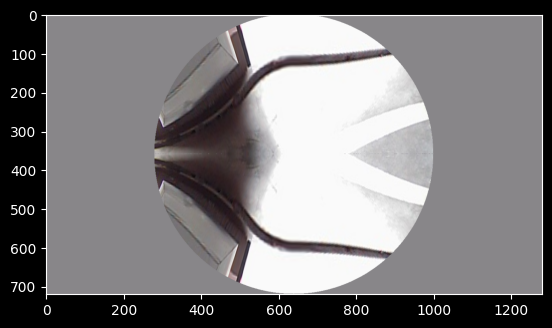

(720, 1280, 3)


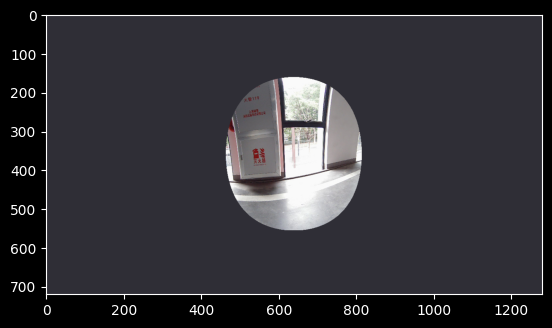

In [39]:
undistorted_img = cv2.remap(np.rot90(img, 1), map_img, 
                            # map_img[:, :, 1], 
                            # map_img[:, :, 0],
                            None, 
                            interpolation=cv2.INTER_LINEAR, 
                            borderMode=cv2.BORDER_CONSTANT)
undistorted_img = np.rot90(np.rot90(undistorted_img))
print(undistorted_img.shape)
cv2_imshow(undistorted_img)

(720, 1280, 3)


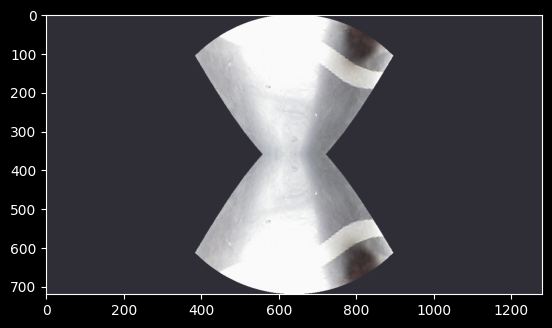

In [46]:
# distorted_img = cv2.remap(np.rot90(undistorted_img, 1), inv_map_img, 
distorted_img = cv2.remap(np.rot90(undistorted_img), inv_map_img, 
                            # map_img[:, :, 1], 
                            # map_img[:, :, 0],
                            None, 
                            interpolation=cv2.INTER_LINEAR, 
                            borderMode=cv2.BORDER_CONSTANT)
# distorted_img = np.rot90(np.rot90(distorted_img))
print(distorted_img.shape)
cv2_imshow(distorted_img)